In [1]:
import subprocess as sp
import numpy as np
import pandas as pd
from io import StringIO
import os
import re
import shutil

#plotting
from matplotlib import pyplot as plt
import matplotlib.patches as mlines
import matplotlib.patches as mpatches
from matplotlib import colors as mcolors
import matplotlib.backends.backend_pdf
import matplotlib.font_manager as font_manager
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

# Global Plot Settings

In [2]:
#some plot objects
lw = 4
ms = 250
colorlist = ['crimson','dodgerblue','darkorchid','forestgreen','goldenrod','silver','darkorange','turquoise'] \
            +[str(name) for name,hex in mcolors.cnames.items()]
markerlist = ['v','s','o','*','^','x','p','8','+','>','<']
xoff = 0.
xwidth = 0.6

plot_target_map = {"step_num": "#steps", "time_ms": "time [min]"}

# Parser Functions

In [5]:
logtoken = ":::MLLOG "

def process_line(line):
    line.replace(logtoken,"")
    null = None
    NaN = np.nan
    return eval(line.replace(logtoken,""))

def parse_log(filename):
    #get run tag from filename
    run_tag, _ = os.path.splitext(os.path.basename(filename))
    
    # read the data
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # parse the lines
    records = []
    for line in lines:
        if line.startswith(logtoken):
            records.append(process_line(line))
            
    recorddf = pd.DataFrame(records)
    recorddf["run_tag"] = run_tag
    
    return recorddf

# Load Data

In [28]:
logdir = "../data/logs"
logfiles = [os.path.join(logdir, x) for x in os.listdir(logdir) if x.endswith(".log")]

# load all logs
dflist = []
for logfile in logfiles:
    print(logfile)
    dflist.append(parse_log(logfile))
    
resultdf = pd.concat(dflist)

#sort
resultdf.sort_values(["run_tag", "time_ms"], inplace=True)

../data/logs/deepcam_prediction_run5_nnodes8-6-debug.log
../data/logs/deepcam_prediction_run5_nnodes32-12-debug.log
../data/logs/deepcam_prediction_run5_nnodes32-9-debug.log
../data/logs/deepcam_prediction_run5_nnodes64-14-debug.log
../data/logs/deepcam_prediction_run5_nnodes32-7-debug.log
../data/logs/deepcam_prediction_run5_nnodes64-13-debug.log
../data/logs/deepcam_prediction_run5_nnodes32-6-debug.log


# Plots

## Train loss

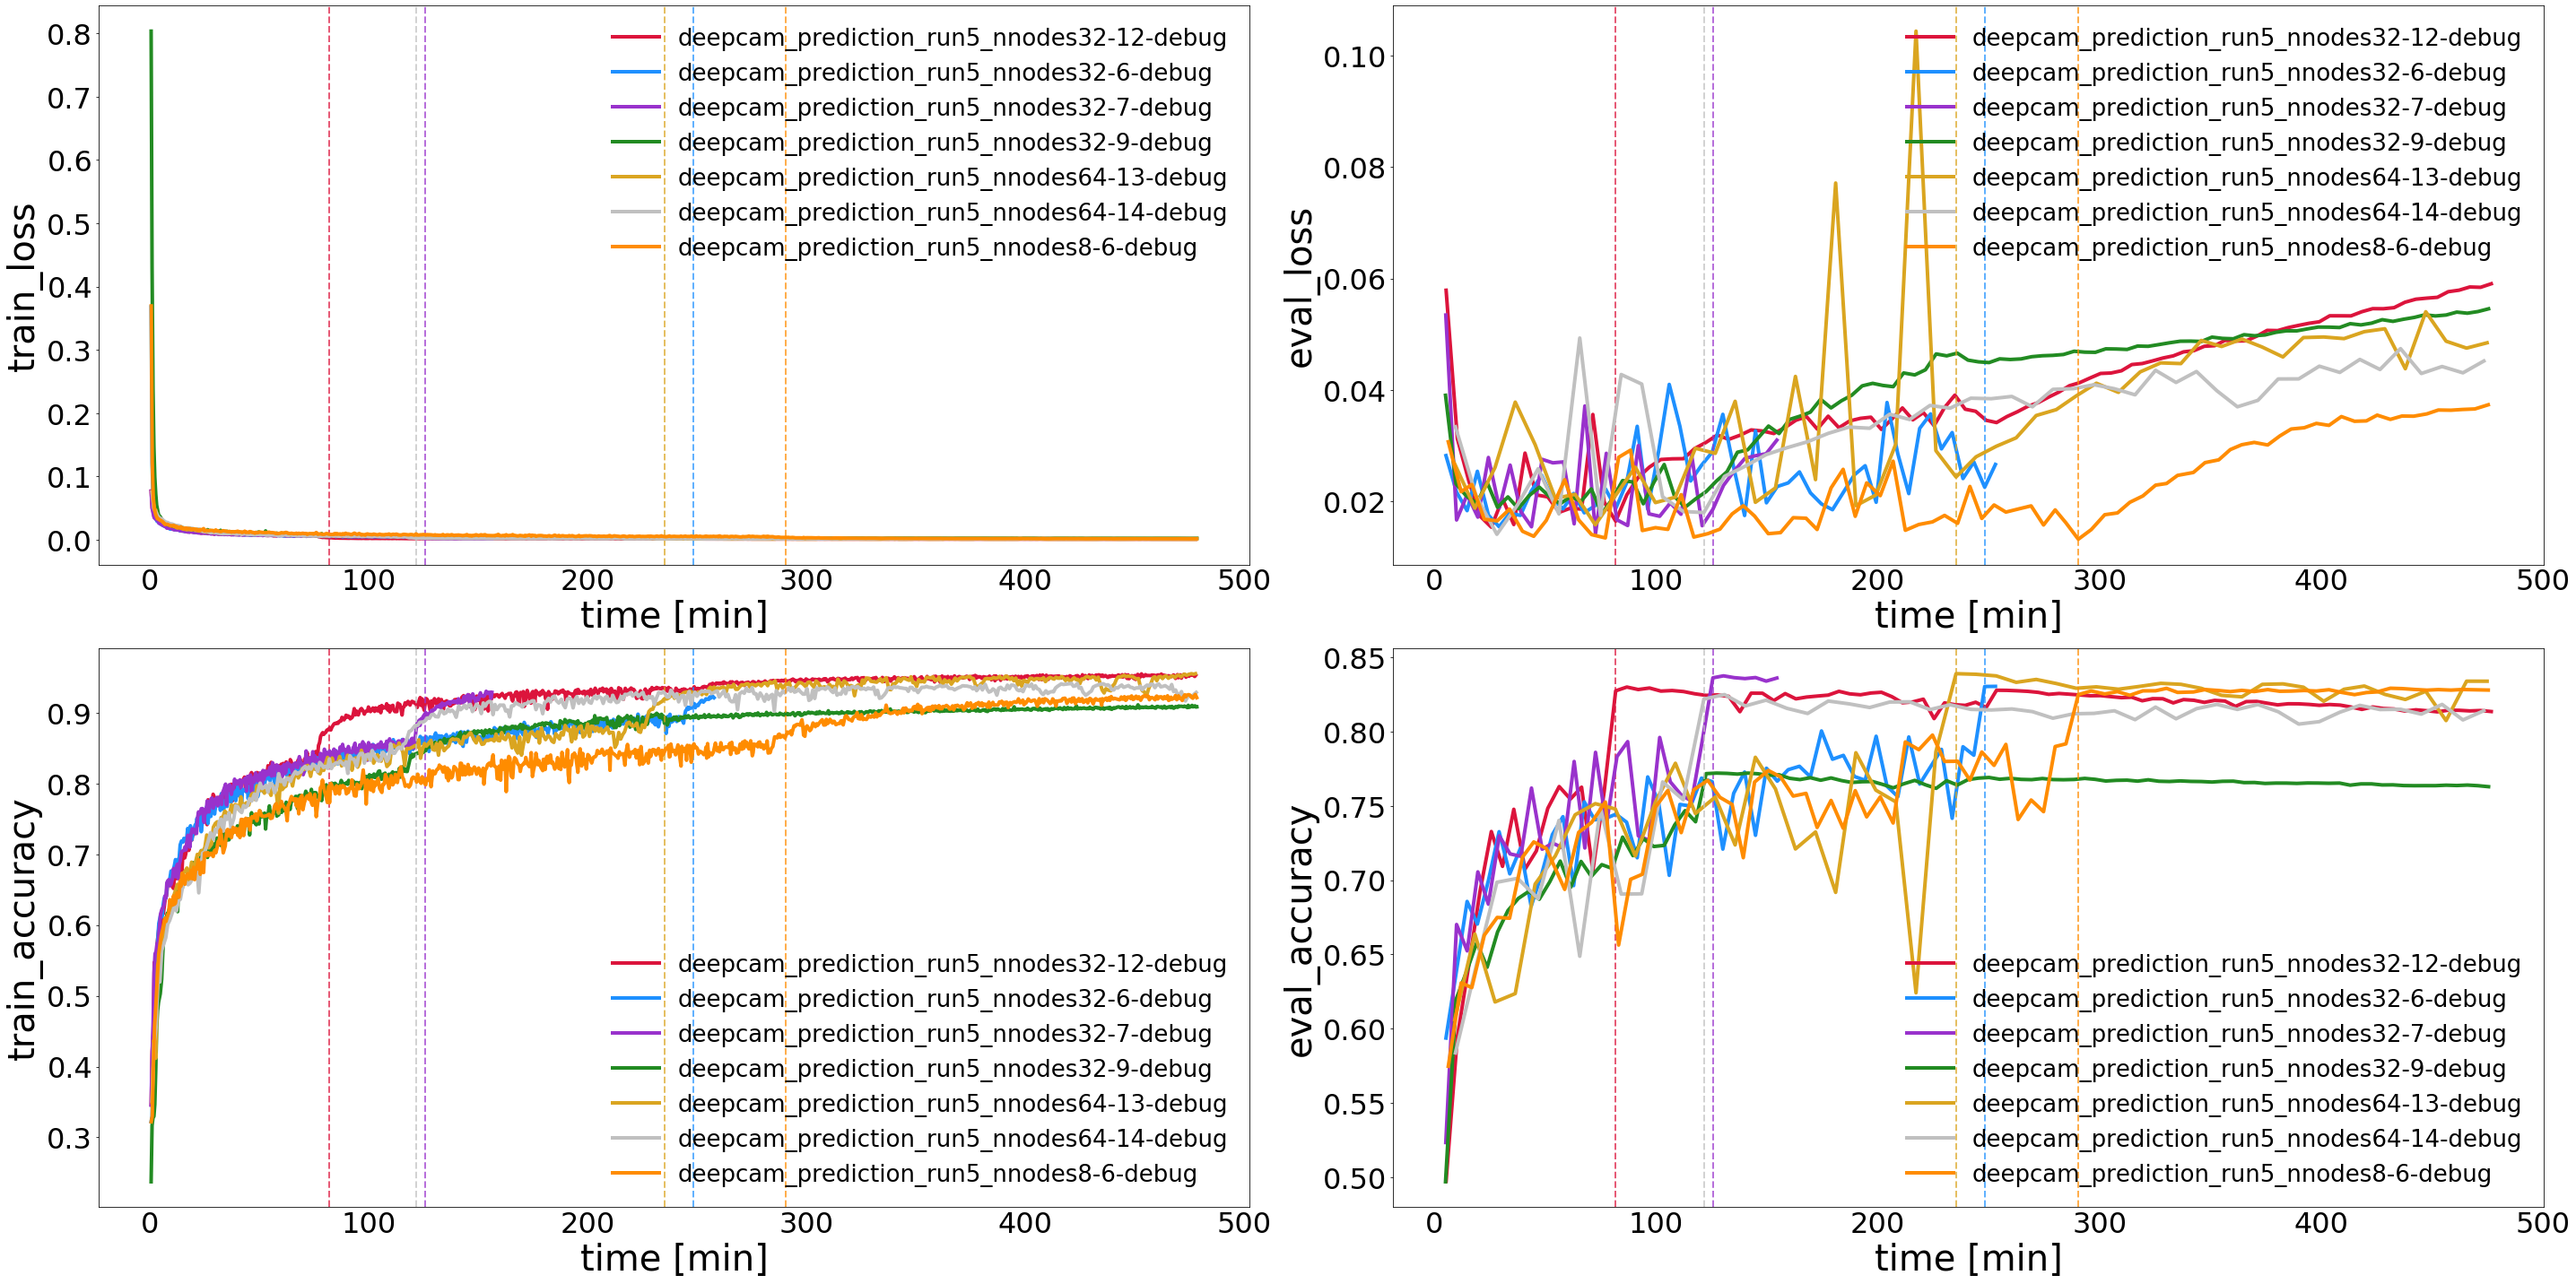

In [37]:
plot_target = "time_ms"

num_rows = 2
num_cols = 2
fig, axvec = plt.subplots(figsize=(20*num_cols, 10*num_rows), nrows = num_rows, ncols = num_cols)

for idr, metric in enumerate(["loss", "accuracy"]):
    for idc, phase in enumerate(["train", "eval"]):
            
        for idx, run_tag in enumerate(resultdf["run_tag"].unique()):
            
            # project for run first
            projdf = resultdf[ resultdf["run_tag"] == run_tag ]
            start_time = projdf.loc[ projdf["key"] == "run_start", "time_ms" ].values[0]    
            
            # project metric
            ykey = phase + "_" + metric
            seldf = projdf.loc[ projdf["key"] == ykey, ["time_ms", "metadata", "value"] ]
            
            # sort again
            #seldf.sort_values([""], inplace=True)
            
            #did we reach the target accuracy?
            if plot_target == "time_ms":
                targetdf = (projdf.loc[ projdf["key"] == "target_accuracy_reached", "time_ms" ] - start_time) / 1000. / 60.
            elif plot_target == "step_num":
                targetdf = projdf.loc[ projdf["key"] == "target_accuracy_reached", "metadata" ].apply(lambda x: x["step_num"])
            x_target = None
            if not targetdf.empty:
                x_target = targetdf.values[0]
            
            #what do we plot against what
            if plot_target == "time_ms":
                xval = (seldf[ "time_ms" ].values - start_time) / 1000. / 60.
            elif plot_target == "step_num":
                xval = seldf["metadata"].apply(lambda x: x["step_num"]).values
            yval = seldf["value"].values
            
            # extract axes and set font size etc
            ax = axvec[idr, idc]
            #format the plot
            for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                label.set_fontsize(32)
            ax.set_ylabel(ykey, size = 40)

            #tick labels
            ax.set_xlabel(plot_target_map[plot_target], size = 40)
            ax.tick_params(axis=u'x', which=u'both',length=0)
            
            #plot
            ax.plot(xval, yval, lw = lw, color = colorlist[idx], label = run_tag)
            #ax.scatter(xval, yval, s = ms, color = colorlist[idx], label = run_tag)
            
            #target
            if x_target is not None:
                ax.axvline(x = x_target, lw = lw // 2, ls = "--", color = colorlist[idx], alpha=0.7)
        
        location = "upper right" if metric == "loss" else "lower right"
        ax.legend(loc = location, ncol = 1, frameon = False, fontsize = 26)
    
plt.tight_layout()

In [32]:
resultdf[ resultdf.run_tag == "deepcam_prediction_run5_nnodes64-13-debug" ]

,namespace,time_ms,event_type,key,value,metadata,run_tag
0,,1593869530453,POINT_IN_TIME,submission_benchmark,deepcam,{'file': '/opt/deepCam/utils/mlperf_log_utils....,deepcam_prediction_run5_nnodes64-13-debug
1,,1593869530532,POINT_IN_TIME,submission_org,Umbrella Corp.,{'file': '/opt/deepCam/utils/mlperf_log_utils....,deepcam_prediction_run5_nnodes64-13-debug
2,,1593869530532,POINT_IN_TIME,submission_division,closed,{'file': '/opt/deepCam/utils/mlperf_log_utils....,deepcam_prediction_run5_nnodes64-13-debug
3,,1593869530532,POINT_IN_TIME,submission_status,onprem,{'file': '/opt/deepCam/utils/mlperf_log_utils....,deepcam_prediction_run5_nnodes64-13-debug
4,,1593869530532,POINT_IN_TIME,submission_platform,1024xSUBMISSION_PLATFORM_PLACEHOLDER,{'file': '/opt/deepCam/utils/mlperf_log_utils....,deepcam_prediction_run5_nnodes64-13-debug
...,...,...,...,...,...,...,...
2083,,1593898143688,INTERVAL_END,epoch_stop,None,"{'file': './train_hdf5_ddp.py', 'lineno': 484,...",deepcam_prediction_run5_nnodes64-13-debug
2084,,1593898143689,INTERVAL_START,epoch_start,None,"{'file': './train_hdf5_ddp.py', 'lineno': 301,...",deepcam_prediction_run5_nnodes64-13-debug
2085,,1593898193705,POINT_IN_TIME,learning_rate,4e-05,"{'file': './train_hdf5_ddp.py', 'lineno': 371,...",deepcam_prediction_run5_nnodes64-13-debug
2086,,1593898193927,POINT_IN_TIME,train_accuracy,0.955067,"{'file': './train_hdf5_ddp.py', 'lineno': 372,...",deepcam_prediction_run5_nnodes64-13-debug
